## Time series analysis - COVID in Ontario
The goal of this project is to develop data science or machine learning models that forecast COVID-19 cases with the aim of helping policymakers plan for the days and months ahead, and take action to change the course of the pandemic for the better. In addition to modelling and projecting COVID-19 cases we will also use Ontario's historical temperature data as a secondary dataset, to understand how case numbers correlate to that dataset. As an output of this comparison we will outline some evidence-based insights, policies and guidelines that would help minimize the case numbers and related adverse effects. 

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import curve_fit
from matplotlib import rcParams
from pylab import *

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# show plots inline for notebooks
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Part 1: Load and Clean Data

Load and extract data about COVID-19 in Ontario

In [2]:
rawJH = pd.read_csv('time_series_covid19_confirmed_global.csv')
rawJH.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12-01-2020,12-02-2020,12-03-2020,12-04-2020,12-05-2020,12-06-2020,12-07-2020,12-08-2020,12-09-2020,12-10-2020
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,46516,46718,46837,46837,47072,47306,47516,47716,47851,48053
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,39014,39719,40501,41302,42148,42988,43683,44436,45188,46061
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,84152,85084,85927,86730,87502,88252,88825,89416,90014,90579
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6790,6842,6904,6955,7005,7050,7084,7127,7162,7190
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15251,15319,15361,15493,15536,15591,15648,15729,15804,15925


In [3]:
rawDFCan = rawJH[rawJH['Province/State'] == 'Ontario']
rawDFCan.index=['Ontario']
rawDFCan.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12-01-2020,12-02-2020,12-03-2020,12-04-2020,12-05-2020,12-06-2020,12-07-2020,12-08-2020,12-09-2020,12-10-2020
Ontario,Ontario,Canada,51.2538,-85.3232,0,0,0,0,1,1,...,121770,123639,125233,127130,128997,130962,132736,134605,136599,138529


## Part 2 - Visualise data

C:\Users\KrishnaPratheeba\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'Case count')

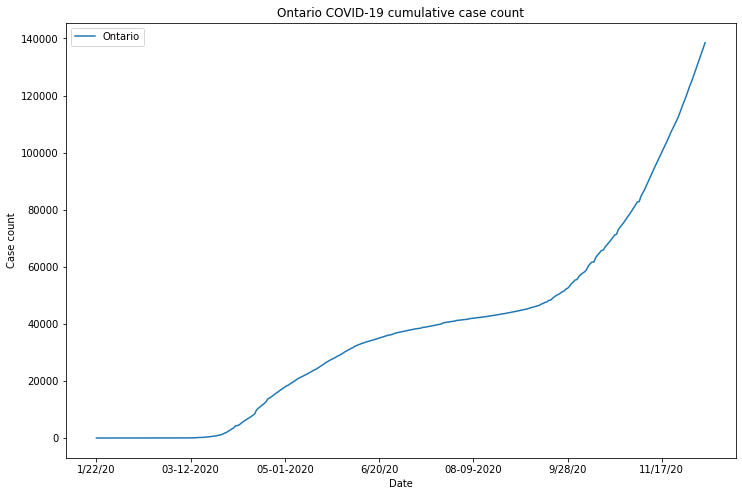

In [4]:
rawDFCan.transpose().iloc[4:].plot(figsize=(12,8))
plt.title('Ontario COVID-19 cumulative case count')
plt.xlabel('Date')
plt.ylabel('Case count')

Text(0, 0.5, 'Case count')

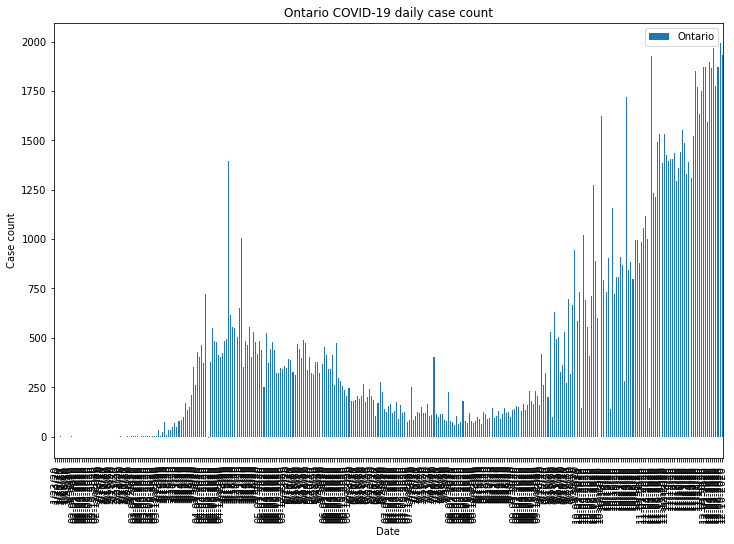

In [5]:
rawDFCan.transpose().iloc[5:].diff(axis=0).plot(kind='bar', figsize=(12,8))
plt.title('Ontario COVID-19 daily case count')
plt.xlabel('Date')
plt.ylabel('Case count')

From the above graph we can see that the data does not follow any seasonal pattern. The third exploratory visualisation of the assignment is provided in part-4 to explain the influence of temperature on COVID-19 cases.

Let us now predict the time series using ARIMA model.

For ARIMA first thing we do is identify if the data is stationary or non – stationary. If data is non-stationary we will try to make them stationary then we will process further. Let’s check that if the given dataset is stationary or not, for that we use adfuller test. We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.

## Part 3 - ARMIA model selection and fitting to data

In [6]:
#Let us first check if the raw data is stationary using the adfuller test.
df = rawDFCan.transpose().iloc[4:]
test_result=adfuller(df['Ontario'])

def adfuller_test(Ontario):
    result=adfuller(Ontario)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Ontario'])

ADF Test Statistic : 1.1108577173325358
p-value : 0.9953082317327255
#Lags Used : 12
Number of Observations : 311
weak evidence against null hypothesis,indicating it is non-stationary 


Since the raw data is non-stationary, let us check the stationarity for first order difference

In [7]:
df['Cases First Difference'] = df['Ontario'] - df['Ontario'].shift(1)
adfuller_test(df['Cases First Difference'].dropna())

ADF Test Statistic : 2.1558339673531353
p-value : 0.9988441539808949
#Lags Used : 11
Number of Observations : 311
weak evidence against null hypothesis,indicating it is non-stationary 


First order difference is not stationary. Again let's check if the data is stationary for second order difference

In [8]:
df['Cases Second Difference'] = df['Cases First Difference'] - df['Cases First Difference'].shift(1)
adfuller_test(df['Cases Second Difference'].dropna())

ADF Test Statistic : -6.042867726226134
p-value : 1.3330472610764992e-07
#Lags Used : 10
Number of Observations : 311
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


C:\Users\KrishnaPratheeba\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 1.0, 'Second Order Difference')

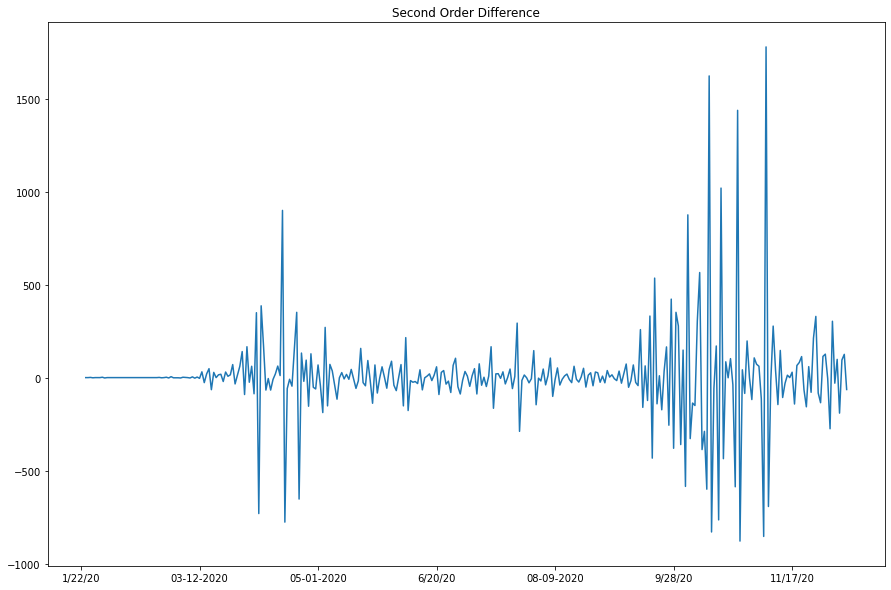

In [9]:
df['Cases Second Difference'].plot(figsize=(15,10))
plt.title('Second Order Difference')

We can see that the p-value for the second order differencing is less than 0.05. So the the value of the d (differencing order) parameter is 2. The plot also shows that the distribution of the residuals does not follow any pattern of seasonality.

Let us now plot the autocorrelation and partial autocorrelation graph of the second order difference to find the approximate order values of the other p (autoregressive) and q (moving average) parameters.

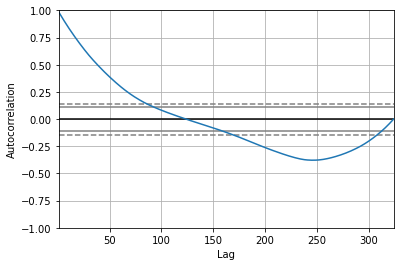

In [10]:
autocorrelation_plot(df['Ontario'])
plt.show()

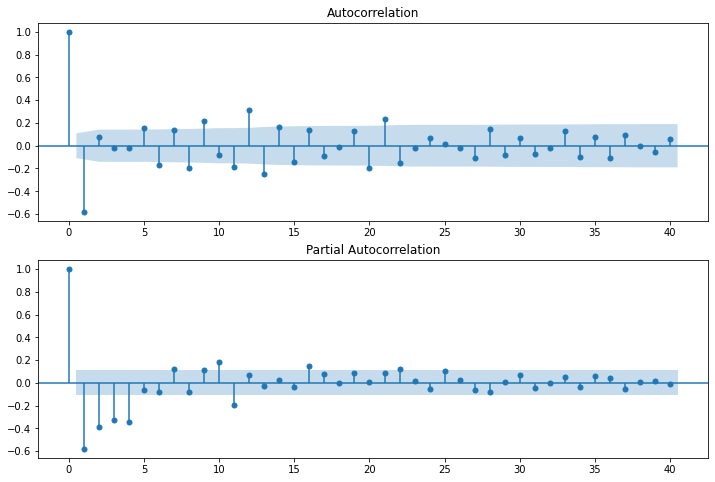

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Cases Second Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Cases Second Difference'].dropna(),lags=40,ax=ax2)

Here, since the ACF (Autocorrelation) value cuts off rapidly after 1 and PACF (Partial Autocorrelation) value tails off slowly, we can say that the most promising q value of the ARIMA model could be 2 and the most promising p value of the model could be 1 or 2.

After identifying the reference values of the p and q parameters, we can validate the best p and q values using a grid search approach. The model with best AIC and BIC values will give the best parameter values.

In [12]:
warnings.filterwarnings('ignore')
order_aic_bic = []
#loop over AR order
for p in range(3):
    #loop over MA order
    for q in range(3):
        #fit model
        model = SARIMAX(df['Ontario'].astype(int), order=(p,2,q))
        results = model.fit()
        # add model and scores to list
        order_aic_bic.append((p,q,results.aic,results.bic))
#make dataframe of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])
#sort by AIC
print(order_df.sort_values('aic'))

   p  q          aic          bic
5  1  2  4247.233437  4262.331644
8  2  2  4248.002226  4266.874984
2  0  2  4254.572479  4265.896134
7  2  1  4261.144515  4276.242721
4  1  1  4265.323771  4276.647425
1  0  1  4281.196165  4288.745268
6  2  0  4308.659029  4319.982684
3  1  0  4357.621008  4365.170111
0  0  0  4486.210471  4489.985022


Here we can see that according to the AIC scores, the best values for the parameters p and q are 1 and 2, respectively

## Model diagnostics
We will now evaluate of model performance with the best parameters (p=1, d=2, q=2) by analysing residuals and histograms

In [13]:
df.index = pd.to_datetime(df.index)

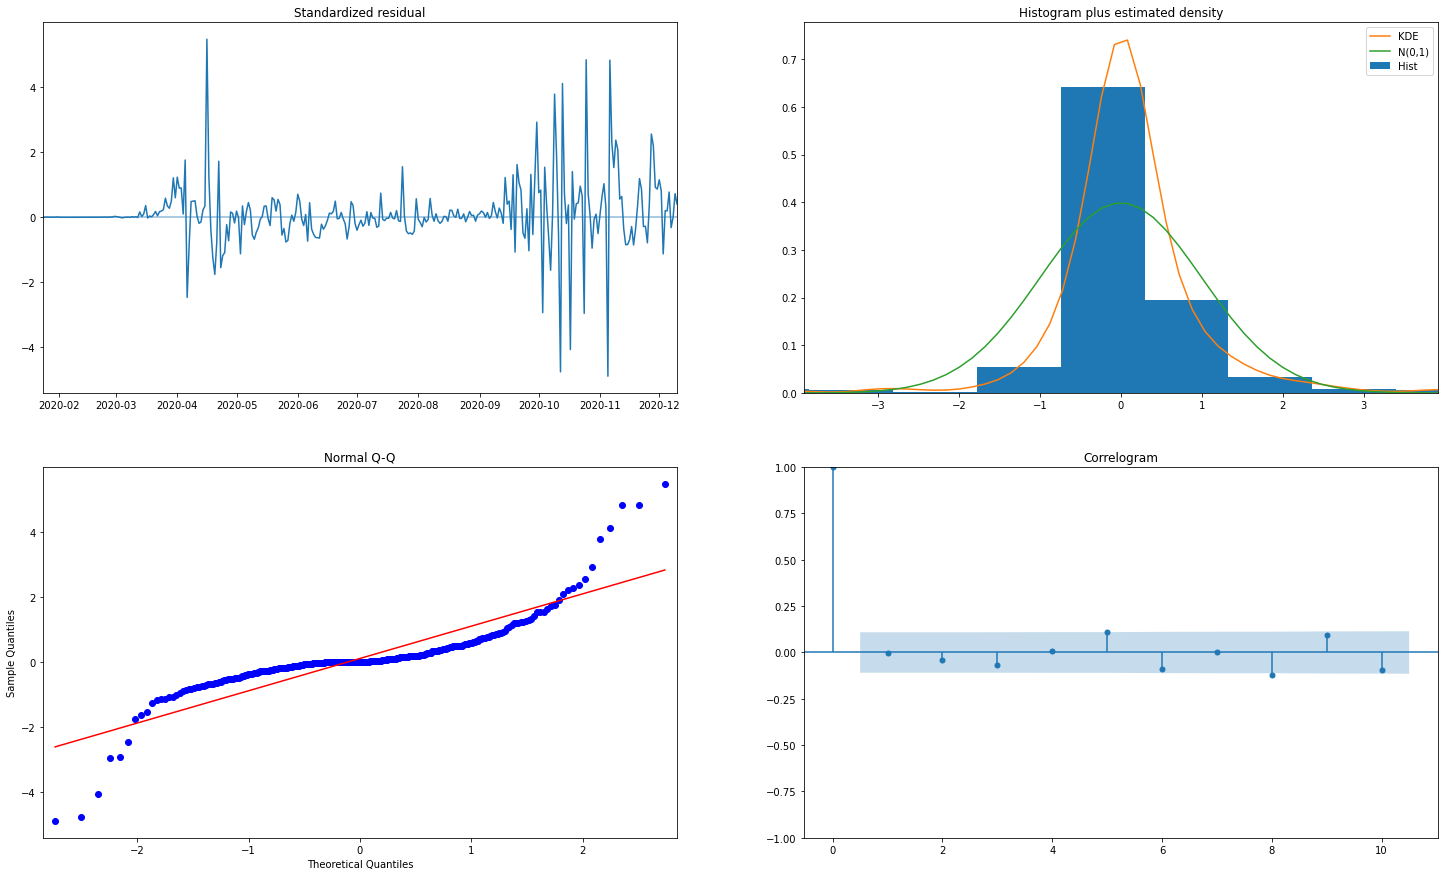

In [14]:
model = SARIMAX(df['Ontario'].astype(float), order=(1,2,2))
results = model.fit()
results.plot_diagnostics(figsize = (25,15))
plt.show()

Here we can see that the residuals do not show any specific pattern. So the data is not seasonal. The histogram shows that the residuals are also normally distributed. The Q-Q graph shows that the residuals are somewhat normally distributed. The correlogram shows that most of the correlations of the lags greater than 0 are not significant. This shows that the model did not leave any information in the data uncaptured.

We can now use this model to make in-sample and out-of-sample predictions.

Text(0, 0.5, 'COVID cases count')

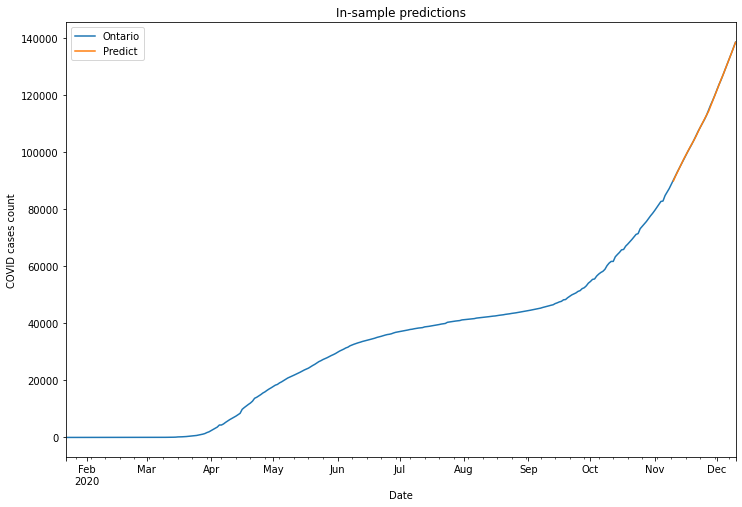

In [15]:
df['Predict']=results.predict(start = '2020-11-10', end='2020-12-10',dynamic=False)
df[['Ontario','Predict']].plot(figsize=(12,8))
plt.title('In-sample predictions')
plt.xlabel('Date')
plt.ylabel('COVID cases count')

From the above plot we can see that our trained model give good results for our in-sample predictions. We can now use it for out-of-sample predictions for 30 days following December 10th, 2020.

Text(0, 0.5, 'COVID cases count')

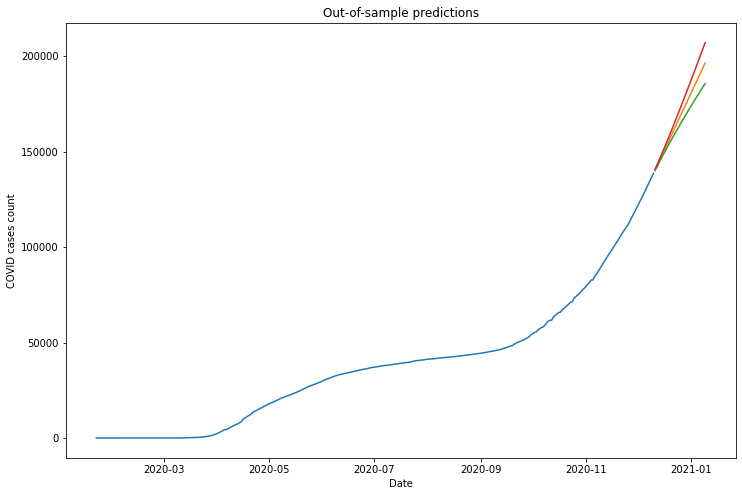

In [16]:
forecast=results.get_forecast(steps = 30,alpha=0.05)
plt.figure(figsize=(12,8))
plt.plot(df[['Ontario']])
plt.plot(forecast.predicted_mean)
plt.plot(forecast.conf_int())
plt.title('Out-of-sample predictions')
plt.xlabel('Date')
plt.ylabel('COVID cases count')

In [17]:
print(forecast.predicted_mean.tail())

2021-01-05    188621.847662
2021-01-06    190551.006582
2021-01-07    192480.165502
2021-01-08    194409.324422
2021-01-09    196338.483342
Freq: D, dtype: float64


In [18]:
forecast.conf_int().tail() #print lower and upper bound of out-of-sample predictions

,lower Ontario,upper Ontario
2021-01-05,179937.512277,197306.183047
2021-01-06,181377.903549,199724.109615
2021-01-07,182809.387827,202150.943177
2021-01-08,184232.125070,204586.523774
2021-01-09,185646.266664,207030.700019


The above prediction show that after 30 days from December 10th, 2020, COVID-19 case count in Ontario will reach 196338.

## Part 4 - Correlating temperature change with COVID-19 cases in Ontario
In this section we will see how temperature change is correlated to the change in COVID-19 cases in Ontario.

In [19]:
#Load the attached climate excel file below for the temperature data for Ontario
climate = pd.read_excel('climate_1.xlsx')
climate.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2020-01-01,2020,1,1,NaN,-1.0,...,NaN,NaN,NaN,M,28.0,NaN,NaN,M,NaN,M
1,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2020-01-02,2020,1,2,NaN,3.0,...,NaN,NaN,NaN,M,28.0,NaN,NaN,NaN,NaN,NaN
2,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2020-01-03,2020,1,3,NaN,3.7,...,NaN,NaN,NaN,M,26.0,NaN,NaN,NaN,NaN,NaN
3,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2020-01-04,2020,1,4,NaN,-0.9,...,NaN,NaN,NaN,M,24.0,NaN,NaN,NaN,NaN,NaN
4,-78.27,45.53,ALGONQUIN PARK EAST GATE,6080192,2020-01-05,2020,1,5,NaN,-2.9,...,NaN,NaN,NaN,M,25.0,NaN,NaN,NaN,NaN,NaN


In [20]:
climate_ontario = climate['Mean Temp']
climate_ontario.index = pd.to_datetime(climate['Date/Time'])
climate_ontario = climate_ontario['2020-01-22':'2020-12-10']
climate_ontario.tail()

Date/Time
2020-12-06   -6.9
2020-12-07   -8.1
2020-12-08   -9.3
2020-12-09   -0.6
2020-12-10   -0.8
Name: Mean Temp, dtype: float64

Text(0, 0.5, 'COVID-19 cases count')

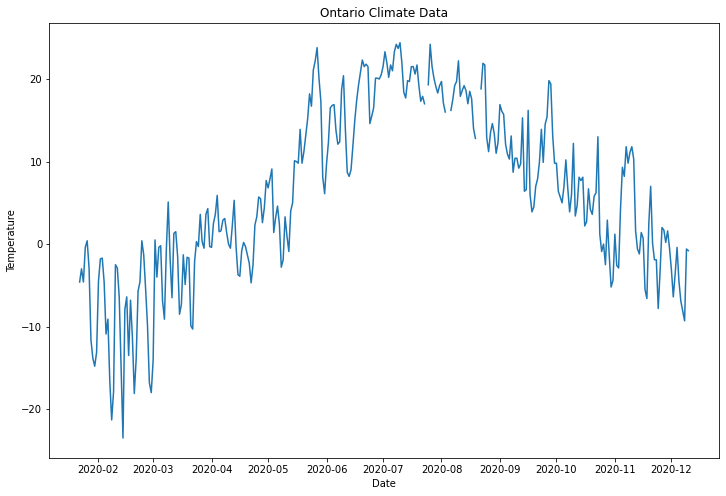

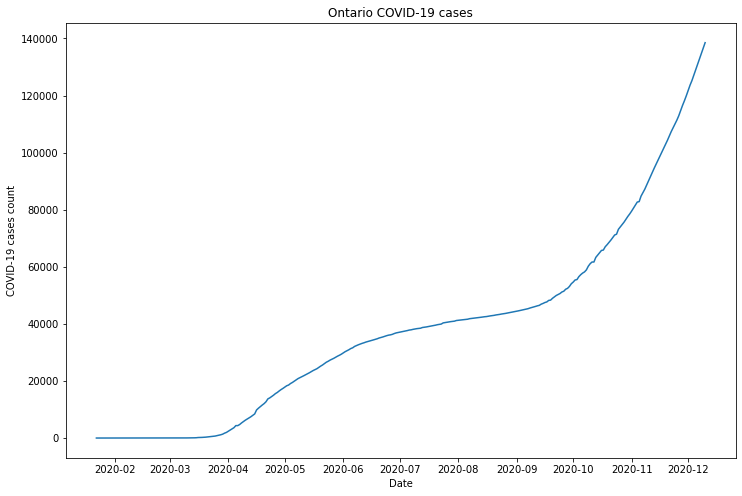

In [21]:
plt.figure(figsize=(12,8))

forecast=results.get_forecast(steps = 30,alpha=0.05)
plt.plot(climate_ontario)
plt.title('Ontario Climate Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.figure(figsize=(12,8))
plt.plot(df[['Ontario']])
plt.title('Ontario COVID-19 cases')
plt.xlabel('Date')
plt.ylabel('COVID-19 cases count')

## Part 5 - Deriving insights

From the above plots we can see that the during the initial stages of the virus spread, the temperature was very low. On March 12, Ontario only had 59 COVID-19 cases. But as the temperature started to rise, the virus spread increased. This could be because the people started to enjoy more outdoor activities in summer. As the temperature peaked in the summer during May, June, July, and August, COVID growth curve was flattened. This could be because of the stricter measures implemented by the province. The province declared the state of emergency during the start of the summer and was extended throughout the summer multiple times. The province also ordered closure of non-essential businesses and indoor/outdoor recreation facilites during the summer.

If such strict measures were not enforced, the province could have suffered more severe damage during the summer, since people are encouraged to socialise more during the summer because of the warm weather. Later, as the temperature drops after september, COVID cases was expected to drop because of the cold weather. On the contrary, the cases increased exponentially. This is because the province-wide restrictions related to COVID are relaxed, which promoted people to gather more in indoor spaces for recreation activities and businesses were allowed to reopen. If the restrictions that were in effect in the summer were also enforced in the winter, the exponential increase in COVID cases would not have been there. Although there are factors other than temperature that influence the COVID-19 growth rate, it is important to take into account the changing behaviour of people in different seasons, which might contribute to the growth of COVID-19. As we are now in the middle of winter, people are not expected to be active outdoors. Hence, we can take this opportunity to continue the COVID related restrictions to substantially reduce the cases before the widespread administration of the vaccine.

Timeline of COVID-related restrictions in Ontario[6]:

    March 17 - Declares state of emergency (some business closed)
    March 23 - Closure of non-essential business for 14 days
    March 30 - Closure of outdoor amenities for 14 days
    April 14 - Extension of state of emergency for 4 more weeks
    May 1 - Seasonal business and construction reopens
    May 6 - Emergency orders extended to May 19
    May 6 - Nurseries and garden centers reopen
    May 9 - Parks reopen
    May 14 - Phase 2 province reopen
    May 27 - Emergency order extended to June 9 (further extended to July 22)
    July 13 - Province enters phase 3 of reopening
    August 14 - Indoor recreation allowed
    September to October - COVID restrictions relaxed

### Bibliography

1. https://www.sciencedirect.com/science/article/pii/S246804272030035X
2. https://link.springer.com/article/10.1007/s41403-020-00165-z
3. https://www.medrxiv.org/content/10.1101/2020.05.20.20107540v2.full.pdf
4. https://www.hindawi.com/journals/jhe/2020/8857346/
5. https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
6. https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/

### Ontario temperature data source
1. https://climate.weather.gc.ca/climate_data/daily_data_e.html?hlyRange=2004-09-01%7C2020-12-16&dlyRange=2004-09-02%7C2020-12-16&mlyRange=2005-05-01%7C2006-12-01&StationID=42967&Prov=ON&urlExtension=_e.html&searchType=stnProv&optLimit=yearRange&StartYear=2020&EndYear=2020&selRowPerPage=25&Line=18&Month=12&Day=16&lstProvince=&timeframe=2&Year=2020